In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras import initializers
from keras.layers import SpatialDropout2D,Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate,AveragePooling2D, UpSampling2D, BatchNormalization, Activation, add,Dropout,Permute,ZeroPadding2D,Add, Reshape
from keras.models import Model, model_from_json
from keras.optimizers import Adam
# from keras.layers.advanced_activations import ELU, LeakyReLU, ReLU, PReLU
# from keras.utils.vis_utils import plot_model
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras import applications, optimizers, callbacks
import matplotlib
import keras
import tensorflow as tf
from keras.layers import *
import json
from tensorflow.keras.metrics import MeanIoU, Recall, Precision, BinaryAccuracy
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
learning_rate = 0.001
from keras.utils import normalize
from keras import backend as K

In [ ]:

def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation=None,dilation=(1,1), name=None):
    '''
    2D Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, dilation_rate=dilation, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    # if(activation == None):
    #     return x

    x = Activation(activation, name=name)(x)

    return x

In [ ]:
def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    return x


In [ ]:
def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block

    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                        int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out

In [ ]:

def ResPath(filters, length, inp):
    '''
    ResPath

    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                          activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                              activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


In [ ]:
# Correct recall for tf
def recall_tf(y_true, y_pred):
    Y_true = tf.dtypes.cast(y_true, tf.float32)
    Y_true = K.flatten(Y_true)
    Y_pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float32)
    Y_pred = K.flatten(Y_pred)

    true_positives = tf.reduce_sum(Y_true * Y_pred)
    possible_positives = tf.reduce_sum(Y_true)
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

In [ ]:
# Correct tf precision
def precision_tf(y_true, y_pred):
    Y_true = tf.dtypes.cast(y_true, tf.float32)
    Y_true = K.flatten(Y_true)
    Y_pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float32)
    Y_pred = K.flatten(Y_pred)

    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(Y_true * Y_pred, 0, 1)))

    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(Y_pred, 0, 1)))

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

In [ ]:
# Correct tf dicecoefficient
def dice_coefficient_tf(y_true, y_pred):
    Y_true = tf.dtypes.cast(y_true, tf.float32)
    Y_true = K.flatten(Y_true)
    Y_pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float32)
    Y_pred = K.flatten(Y_pred)

    smooth = 1e-5

    intersection = tf.reduce_sum(Y_true * Y_pred)
    union = tf.reduce_sum(Y_true) + tf.reduce_sum(Y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)


In [ ]:
# Pre-Processing the training data
n_classes = 3
X_train = np.load('/content/drive/MyDrive/Dataset/liver_dataset_improoved/train2/X_train128.npy')
Y_train = np.load('/content/drive/MyDrive/Dataset/liver_dataset_improoved/train2/Y_train128.npy')

X_test = np.load('/content/drive/MyDrive/Dataset/liver_dataset_improoved/X_test128.npy')
Y_test = np.load('/content/drive/MyDrive/Dataset/liver_dataset_improoved/Y_test128.npy')

X_train = np.expand_dims(X_train, axis = 3)
#Normalizing X_train values only
X_train = normalize(X_train, axis = 1)

X_test = np.expand_dims(X_test, axis = 3)
X_test = normalize(X_test, axis = 1)


Y_train = np.expand_dims(Y_train, axis = 3)
Y_test = np.expand_dims(Y_test, axis = 3)

print("Training Data")
print(X_train.shape)
print(np.unique(X_train))

print(Y_train.shape)
print(np.unique(Y_train))

# Connverting the Y_train into categorical
Y_train_cat = to_categorical(Y_train, num_classes=n_classes)
Y_train_cat = Y_train_cat.reshape((Y_train.shape[0], Y_train.shape[1], Y_train.shape[2], n_classes))
print(Y_train_cat.shape)

Y_test_cat = to_categorical(Y_test, num_classes=n_classes)
Y_test_cat = Y_test_cat.reshape((Y_test.shape[0], Y_test.shape[1], Y_test.shape[2], n_classes))
print(Y_test_cat.shape)

Training Data
(10000, 128, 128, 1)
[0.00000000e+00 5.22079475e-04 5.32547051e-04 ... 9.99986437e-01
 9.99988443e-01 1.00000000e+00]
(10000, 128, 128, 1)
[0 1 2]
(10000, 128, 128, 3)
(1916, 128, 128, 3)


In [ ]:

def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation=None,dilation=(1,1), name=None):
    '''
    2D Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, dilation_rate=dilation, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    # if(activation == None):
    #     return x

    x = Activation(activation, name=name)(x)

    return x

In [ ]:

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1
n_classes = 3  # 0, 1, 2

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

mresblock1 = MultiResBlock(32, inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
mresblock1 = ResPath(32, 4, mresblock1)

mresblock2 = MultiResBlock(32*2, pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
mresblock2 = ResPath(32*2, 3, mresblock2)

mresblock3 = MultiResBlock(32*4, pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
mresblock3 = ResPath(32*4, 2, mresblock3)

mresblock4 = MultiResBlock(32*8, pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
mresblock4 = ResPath(32*8, 1, mresblock4)

mresblock5 = MultiResBlock(32*16, pool4)

up6 = concatenate([Conv2DTranspose(
    32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
mresblock6 = MultiResBlock(32*8, up6)

up7 = concatenate([Conv2DTranspose(
    32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
mresblock7 = MultiResBlock(32*4, up7)

up8 = concatenate([Conv2DTranspose(
    32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
mresblock8 = MultiResBlock(32*2, up8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
    2, 2), padding='same')(mresblock8), mresblock1], axis=3)
mresblock9 = MultiResBlock(32, up9)
        # 1       1         1         same            1,1             sigmoid         1,1             none
#(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation=None,dilation=(1,1), name=None)

# x = Conv2D(filters, (num_row, num_col), strides=strides, dilation_rate=dilation, padding=padding, use_bias=False)(x)
#     x = BatchNormalization(axis=3, scale=False)(x)

#     # if(activation == None):
#     #     return x

#     x = Activation(activation, name=name)(x)


# conv10 = Conv2D(n_classes, (1, 1), strides=(1,1), dilation_rate=(1,1), padding='same', use_bias=False)(mresblock9)
# conv10 = BatchNormalization(axis=3, scale=False)(conv10)
# conv10 = Activation('softmax')(conv10)

# conv10 = tf.keras.layers.Conv2D(n_classes, (1, 1), activation= 'softmax')(mresblock9)
# conv10 = conv2d_bn(mresblock9, 3, 1, 1, activation='softmax')

conv10 = tf.keras.layers.Conv2D(n_classes, (1, 1), activation= 'softmax')(mresblock9)

model = Model(inputs=inputs, outputs=conv10)

# model = tf.keras.models.load_model('/content/drive/MyDrive/Project7thSem/Heart_Dataset/MultiResUnet/EarlyStopping/BFLoss/model_for_heart128.h5',custom_objects={'recall_tf': recall_tf, 'precision_tf': precision_tf, 'dice_coefficient_tf': dice_coefficient_tf})

# with open('/content/drive/MyDrive/Project7thSem/Heart_Dataset/MultiResUnet/EarlyStopping/BFLoss/training_history128.json', 'r') as file:
#     results = json.load(file)

# number_of_epochs_completed = len(results['loss'])


model.compile(
    optimizer=Adam(learning_rate),
    loss= 'categorical_crossentropy',
    metrics=[
        BinaryAccuracy(name='accuracy'),  # Binary Accuracy
        MeanIoU(num_classes=3, name='iou'),  # Intersection Over Union (IoU)
        recall_tf,  # Sensitivity
        precision_tf,
         tf.keras.metrics.BinaryIoU(
            threshold=0.5,
            name='binaryIoU',
            dtype=None
        ),
        Recall(name='recall_inbuilt'),
        Precision(name='precision_inbuilt'),
        dice_coefficient_tf  # Custom dice coefficient function
    ]
)
# model.summary()
checkpointer = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Project7thSem/Liver/MutliResUnet/Categorical/liver_checkpointer.h5', verbose=1, save_best_only=True)


callbacks = [
               tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss'),
              tf.keras.callbacks.TensorBoard(log_dir = '/content/drive/MyDrive/Project7thSem/Liver/MutliResUnet/Categorical'),
              checkpointer
]

# Saving the accuracy as the model gets trained

results = model.fit(X_train, Y_train_cat, validation_split=0.1, batch_size=16, epochs=100, callbacks=callbacks)
model.save('/content/drive/MyDrive/Project7thSem/Liver/MutliResUnet/Categorical/multiresunet_liver_model128.h5')


# Saving the data
with open('/content/drive/MyDrive/Project7thSem/Breast_Dataset_Final/MultiResUnet/EarlyStopping/Binary/training_history128.json', 'w') as file:
     json.dump(results.history, file)
    # return model

Epoch 1/100
563/563 [==============================] - ETA: 0s - loss: 0.1189 - accuracy: 0.9833 - iou: 0.3333 - recall_tf: 0.9671 - precision_tf: 0.9791 - binaryIoU: 0.9630 - recall_inbuilt: 0.9671 - precision_inbuilt: 0.9825 - dice_coefficient_tf: 0.9718
Epoch 1: val_loss improved from inf to 0.10376, saving model to /content/drive/MyDrive/Project7thSem/Liver/MutliResUnet/Categorical/liver_checkpointer.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


563/563 [==============================] - 195s 264ms/step - loss: 0.1189 - accuracy: 0.9833 - iou: 0.3333 - recall_tf: 0.9671 - precision_tf: 0.9791 - binaryIoU: 0.9630 - recall_inbuilt: 0.9671 - precision_inbuilt: 0.9825 - dice_coefficient_tf: 0.9718 - val_loss: 0.1038 - val_accuracy: 0.9865 - val_iou: 0.3333 - val_recall_tf: 0.9769 - val_precision_tf: 0.9825 - val_binaryIoU: 0.9702 - val_recall_inbuilt: 0.9770 - val_precision_inbuilt: 0.9825 - val_dice_coefficient_tf: 0.9797
Epoch 2/100
563/563 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.9939 - iou: 0.3333 - recall_tf: 0.9903 - precision_tf: 0.9914 - binaryIoU: 0.9864 - recall_inbuilt: 0.9903 - precision_inbuilt: 0.9914 - dice_coefficient_tf: 0.9908
Epoch 2: val_loss improved from 0.10376 to 0.02230, saving model to /content/drive/MyDrive/Project7thSem/Liver/MutliResUnet/Categorical/liver_checkpointer.h5
563/563 [==============================] - 142s 252ms/step - loss: 0.0279 - accuracy: 0.9939 - iou: 0.

In [ ]:
results = model.evaluate(X_test, Y_test_cat)

60/60 [==============================] - 14s 171ms/step - loss: 0.0074 - accuracy: 0.9983 - iou: 0.4656 - recall_tf: 0.9974 - precision_tf: 0.9974 - binaryIoU: 0.9961 - recall_inbuilt: 0.9974 - precision_inbuilt: 0.9974 - dice_coefficient_tf: 0.9974


In [ ]:
labels = ['loss', 'accuracy', 'iou', 'recall', 'precision', 'binaryIoU', 'recall_inbuilt', 'precision_inbuilt', 'dice_coefficient_tf']
results_dict = dict(zip(labels, results))

with open('/content/drive/MyDrive/Project7thSem/Liver/MutliResUnet/Categorical/Graph/testing_results_final.json', 'w') as json_file:
    json.dump(results_dict, json_file)

In [ ]:
Y_pred = model.predict(X_test)
Y_pred_argmax = np.argmax(Y_pred, axis=3)

60/60 [==============================] - 8s 108ms/step


In [ ]:
from keras.metrics import MeanIoU

n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(Y_test[:,:,:,0], Y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.9373787


In [ ]:
# To calculate IoU for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)

class1_IoU = values[0, 0] / (values[0, 0] + values[0, 1] + values[0, 2] + values[1, 0] + values[2, 0])
class2_IoU = values[1, 1] / (values[1, 1] + values[1, 0] + values[1, 2] + values[0, 1] + values[2, 1])
class3_IoU = values[2, 2] / (values[2, 2] + values[2, 0] + values[2, 1] + values[0, 2] + values[1, 2])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)


[[1.6777216e+07 3.0150000e+04 4.5900000e+02]
 [3.4722000e+04 1.9786180e+06 9.8620000e+03]
 [4.6600000e+02 6.4670000e+03 1.0212100e+05]]
IoU for class1 is:  0.9960936
IoU for class2 is:  0.96057856
IoU for class3 is:  0.85546386


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Project7thSem/Liver/MutliResUnet/Categorical/multiresunet_liver_model128.h5',custom_objects={'recall_tf': recall_tf, 'precision_tf': precision_tf, 'dice_coefficient_tf': dice_coefficient_tf})
prediction = (model.predict(X_test))

60/60 [==============================] - 21s 144ms/step


In [ ]:
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 0s 30ms/step


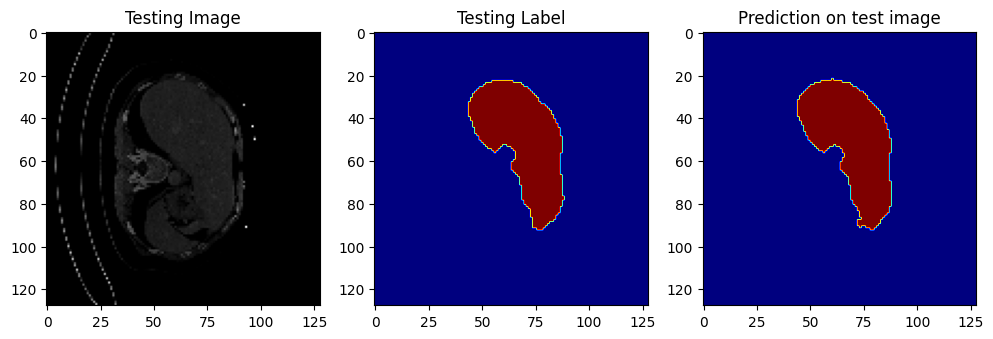

In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=Y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()